### 1. 升级boto3, sagemaker python sdk

In [ ]:
!pip install --upgrade boto3 sagemaker

In [2]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session
from sagemaker import Model, image_uris, serializers, deserializers

role = get_execution_role()
sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()['Account']
print(f'account id:{account_id}')

print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
account id:687912291502
sagemaker sdk version: 2.232.2
role:  arn:aws:iam::687912291502:role/service-role/AmazonSageMaker-ExecutionRole-20211013T113123  
bucket:  sagemaker-us-west-2-687912291502


### 2. 编译docker image (comfyui-inference)

In [13]:
## You should change below region code to the region you used, here sample is use us-west-2
!aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-west-2.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [ ]:
!./build_and_push_async.sh

In [5]:
!touch dummy
!tar czvf model.tar.gz dummy
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-us-west-2-687912291502/stablediffusion/assets/model.tar.gz


#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [6]:
!aws s3 ls s3://sagemaker-us-west-2-687912291502/stablediffusion/assets/model.tar.gz

2024-10-17 13:33:41        114 model.tar.gz


#### 3.2 创建 model 配置

In [17]:
endpoint_name = f'AIGC-ComfyUI-{str(uuid.uuid4())}'

print(f'终端节点:{endpoint_name} 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态')

response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)



终端节点:AIGC-ComfyUI-487e36da-ef30-4299-b5dc-f47502cd8be2 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态


* 检查endpoint 状态

In [ ]:
import time
def check_sendpoint_status(endpoint_name,timeout=600):
    client = boto3.client('sagemaker')
    current_time=0
    while current_time<timeout:
        client = boto3.client('sagemaker')
        try:
            response = client.describe_endpoint(
            EndpointName=endpoint_name
            )
            if response['EndpointStatus'] !='InService':
                raise Exception (f'{endpoint_name} not ready , please wait....')
        except Exception as ex:
            print(f'{endpoint_name} not ready , please wait....')
            time.sleep(10)
        else:
            status = response['EndpointStatus']
            print(f'{endpoint_name} is ready, status: {status}')
            break

check_sendpoint_status(endpoint_name)

### 4. deploy(ssh debug inference）

In [ ]:
!pip install sagemaker_ssh_helper

In [7]:
env={
        's3_bucket': bucket,
        #'CLIP_MODEL_PATH': "s3://sagemaker-us-west-2-687912291502/models/clip",
        'UNET_MODEL_PATH': "s3://sagemaker-us-west-2-687912291502/models/flux",
        #'CONTROLNET_MODEL_PATH':"s3://sagemaker-us-west-2-687912291502/models/controlnet",
        #'OTHER_MODEL_PATHS':"sams|s3://sagemaker-us-west-2-687912291502/models/sam;grounding-dino|s3://sagemaker-us-west-2-687912291502/models/groundingdino"
    }

In [8]:
container=f"{account_id}.dkr.ecr.{aws_region}.amazonaws.com/comfyui-inference:latest"
print(container)

687912291502.dkr.ecr.us-west-2.amazonaws.com/comfyui-inference:latest


In [13]:
from sagemaker_ssh_helper.wrapper import SSHModelWrapper

#container="687912291502.dkr.ecr.us-west-2.amazonaws.com/comfyui-inference:latest"
model = Model(image_uri=container, 
              model_data=model_data, 
              role=role,
              env=env,
              dependencies=[SSHModelWrapper.dependency_dir()] )

In [ ]:
instance_type = "ml.g5.2xlarge"
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker_ssh_helper.wrapper import SSHModelWrapper

endpoint_name = sagemaker.utils.name_from_base("comfyui-byoc")
async_config = AsyncInferenceConfig(
    output_path=f's3://sagemaker-{aws_region}-{account_id}/async-output',  # 替换为您的S3输出路径
)

ssh_wrapper = SSHModelWrapper.create(model, connection_wait_time_seconds=0)
model.deploy(initial_instance_count=1,
             instance_type=instance_type,
             endpoint_name=endpoint_name,
             container_startup_health_check_timeout=800,
             async_inference_config=async_config
            )
# our requests and responses will be in json format so we specify the serializer and the deserializer

#print(f"To connect over SSH run: sm-local-ssh-training connect {ssh_wrapper.training_job_name()}")


---------------

In [ ]:
instance_ids = ssh_wrapper.get_instance_ids(timeout_in_sec=900)  # <--NEW-- 
print(f"To connect over SSM run: aws ssm start-session --target {instance_ids[0]}")

## 4.测试

#### 4.1 创建测试辅助方法 

In [10]:
import time
import datetime
import uuid
import io
import traceback
from PIL import Image
import boto3
import json
import matplotlib.pyplot as plt
from PIL import Image

s3_client = boto3.client('s3')


def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_client = boto3.resource('s3')
    s3_object = s3_client.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    wait_async_result(result)


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        print("job is not completed, waiting...")   
        return False

def get_result(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print(predictions['result'])
        return predictions
    except Exception as e:
        print("result is not completed, waiting...")   


def show_image(result):
    try:
        for image in result['prediction']:
            bucket, key = get_bucket_and_key(image)
            obj = s3_client.get_object(Bucket=bucket, Key=key)
            bytes = obj['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            #resize image to 50% size
            half = 0.5
            out_image = image.resize([int(half * s) for s in image.size])
            out_image.show()

    except Exception as e:
        print("result is not completed, waiting...")


def show_gifs(result):
    import base64
    from IPython import display
    try:
        predictions = result['prediction']
        s3_file_path = predictions[0]
        print("s3 generated gifs path is {}".format(s3_file_path))
        bucket_name, key = get_bucket_and_key(s3_file_path)
        timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        local_file_path="./ComfyUI_"+timestamp+".gif"
        s3_client.download_file(bucket_name, key, local_file_path)
        with open(local_file_path, 'rb') as fd:
            b64 = base64.b64encode(fd.read()).decode('ascii')
        return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')
    except Exception as e:
        print(e)
        print("result is not completed, waiting...")

        
def wait_async_result(output_location,timeout=60):
    current_time=0
    result = None
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result")
            result=get_result(output_location)
            break
        else:
            time.sleep(5)
    return result

def check_sendpoint_status(endpoint_name,timeout=600):
    client = boto3.client('sagemaker')
    current_time=0
    while current_time<timeout:
        client = boto3.client('sagemaker')
        try:
            response = client.describe_endpoint(
            EndpointName=endpoint_name
            )
            if response['EndpointStatus'] !='InService':
                raise Exception (f'{endpoint_name} not ready , please wait....')
        except Exception as ex:
            print(f'{endpoint_name} not ready , please wait....')
            time.sleep(10)
        else:
            status = response['EndpointStatus']
            print(f'{endpoint_name} is ready, status: {status}')
            break

In [11]:
endpoint_name="comfyui-byoc-2024-09-29-10-39-28-010"

#### 5. 测试flux workflow

In [12]:
prompt_json_file="./sample_workflows/flux_workflow_api.json"
import uuid
import json
import base64


prompt_text=""
with open(prompt_json_file) as f:
    prompt_text = json.load(f)

prompt_text['6']['inputs']['text']= "A Fox running on the black forest, the sun is shining"
prompt_text['37']['inputs']['ckpt_name']='flux1-schnell-fp8.safetensors'


client_id = str(uuid.uuid4())
payload={
     "client_id":client_id,
     "prompt": prompt_text,
     "inference_type":"text2img",
     "method":"queue_prompt"
}
result = predict_async(endpoint_name,payload)

{'ResponseMetadata': {'RequestId': '70911565-e6fb-487a-b164-9fa3f569951c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '70911565-e6fb-487a-b164-9fa3f569951c', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Sat, 28 Sep 2024 14:12:18 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '53', 'connection': 'keep-alive'}, 'RetryAttempts': 0}, 'ContentType': 'application/json; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7fa601846fb0>}
{'prompt_id': '0b274e91-f14b-47c5-b577-764d38bac8a1'}


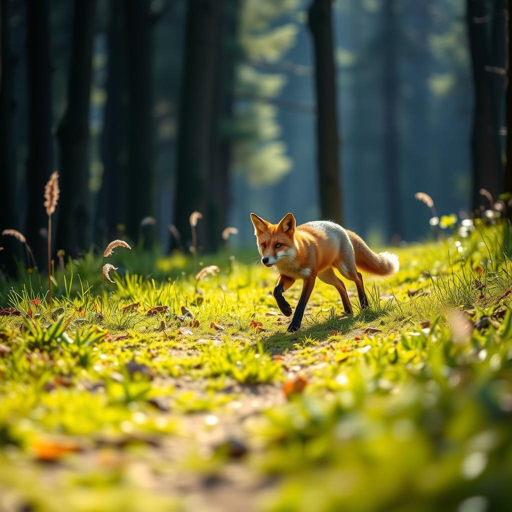

In [12]:
show_image(result)

In [8]:
!aws s3 cp s3://sagemaker-us-west-2-687912291502/comfyui_output/images/0549ac24-62ab-4d4a-b9c1-c97e2aa96dbc.jpg ./

download: s3://sagemaker-us-west-2-687912291502/comfyui_output/images/0549ac24-62ab-4d4a-b9c1-c97e2aa96dbc.jpg to ./0549ac24-62ab-4d4a-b9c1-c97e2aa96dbc.jpg


### 5 清除资源

* gui demo 

In [ ]:
!pip install gradio==4.44.1

In [ ]:
!python deploy_gui_async.py

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
account id:687912291502
sagemaker sdk version: 2.188.0
role:  arn:aws:iam::687912291502:role/service-role/AmazonSageMaker-ExecutionRole-20211013T113123  
bucket:  sagemaker-us-west-2-687912291502
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.1, however version 5.0.1 is availabl

In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
